In [22]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from quantbullet import set_figsize
import quantbullet.research.jump_model as jm
from quantbullet.research.momentum import (
    compute_ex_ante_volatility, 
    compute_log_returns,
    generate_ts_momentum_signal,
)
from quantbullet.utils import (
    plot_price_logret_volatility,
    plot_price_with_signal,
    plot_shared_x
)

import importlib
import quantbullet.research.momentum
importlib.reload(quantbullet.research.momentum)

+-------------------------+
|  Package : quantbullet  |
|  Author  : Yiming Zhang |
|  Version : 0.1.0        |
|  Note    : BETA version |
+-------------------------+


<module 'quantbullet.research.momentum' from '/home/yiming/dev/quantbullet/src/quantbullet/research/momentum.py'>

In [81]:
import importlib
import quantbullet.utils
importlib.reload(quantbullet.utils)

<module 'quantbullet.utils' from '/home/yiming/dev/quantbullet/src/quantbullet/utils/__init__.py'>

In [68]:
# activate the autoreload of modules
%load_ext autoreload
%autoreload 2

In [5]:
import yfinance as yf
# Define the ticker symbol
ticker_symbol = "TSLA"
# Fetch data
data = yf.download(ticker_symbol, start="2018-01-01", end="2023-12-31")

[*********************100%%**********************]  1 of 1 completed


In [6]:
log_ret = compute_log_returns(data['Adj Close'])
exante_vol = compute_ex_ante_volatility(log_ret)

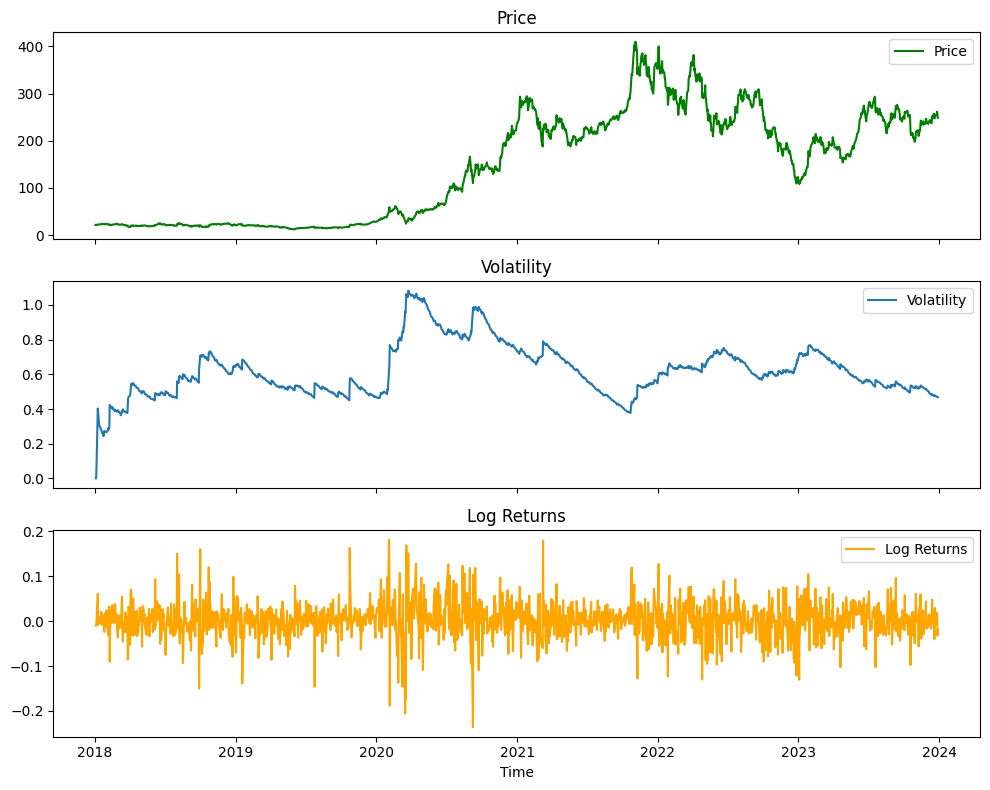

In [7]:
plot_price_logret_volatility(data['Adj Close'], log_ret, exante_vol);

## Use 2018-2020 data to model the parameters

In [23]:
price = data['Adj Close']
train_price = price[:'2020-12-31']
test_price = price['2021-01-01':]
log_ret = compute_log_returns(data['Adj Close'])
train_ret = log_ret[:'2020-12-31']
test_ret = log_ret['2021-01-01':]

In [15]:
enriched_returns = jm.FeatureGenerator().enrich_features(train_ret)
enriched_returns = jm.FeatureGenerator().standarize_features(enriched_returns)

In [16]:
ctsJump = jm.ContinuousJumpModel()
best_states, best_loss, best_thetas = ctsJump.fit(enriched_returns, k=2, lambda_=100, n_trials=10)

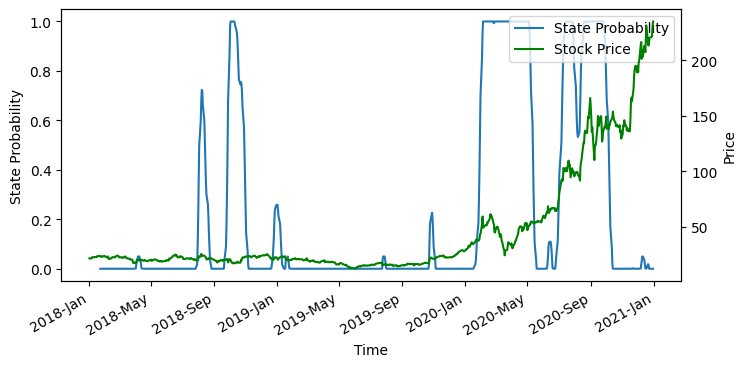

In [17]:
remapped_states, remapped_thetas = jm.arrange_state_prob_by_volatility(enriched_returns[:, 0], best_states, best_thetas, 0.5)
with set_figsize(8, 4):
    # Two states maybe flipped, so we need to rearrange them
    jm.TestingUtils().plot_state_probs(remapped_states, data['Adj Close'][:'2020-12-31'])

## Test the 2021-2023 data

In [18]:
enriched_returns = jm.FeatureGenerator().enrich_features(test_ret)
enriched_returns = jm.FeatureGenerator().standarize_features(enriched_returns)

In [107]:
test_probs = ctsJump.predict(enriched_returns, 
                             remapped_thetas, 
                             lambda_=10)

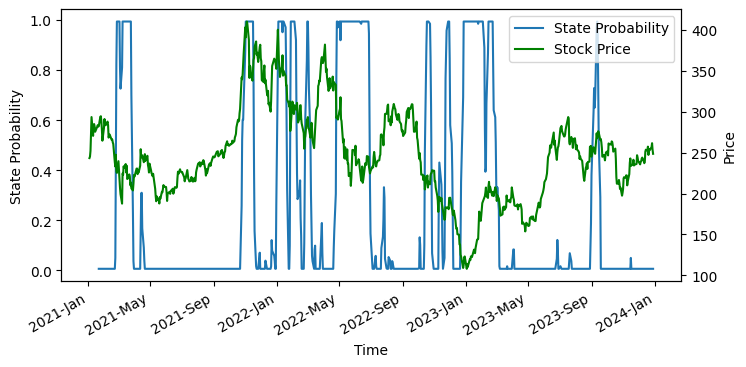

In [108]:
with set_figsize(8, 4):
    jm.TestingUtils().plot_state_probs(test_probs,
                                       test_price)

The prediction does not seem to identify same pattern every time up or down, though I do think it captured the unilateral (one-sided) market. From the volatility chart below, we see the model seems to predict well for a volatility spike.

The sharp increase in volatility may be associated with a market crash / market surge, so we see unilateral movement in the market. These observations may support a momentum strategy.

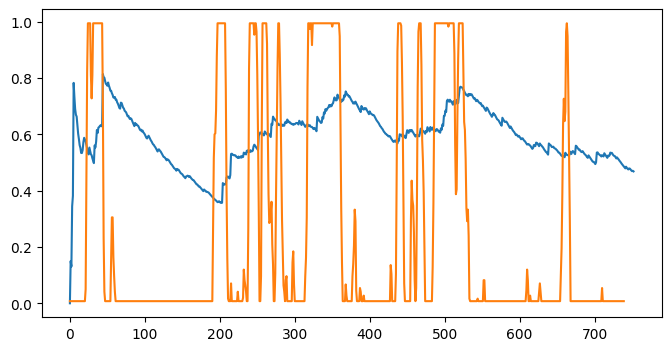

In [39]:
exante_vol = compute_ex_ante_volatility(test_ret)
with set_figsize(8, 4):
    plt.plot(exante_vol.values);
    plt.plot(test_probs[:, 1]);

In [125]:
test_momentum_signal = generate_ts_momentum_signal(test_ret, 10)

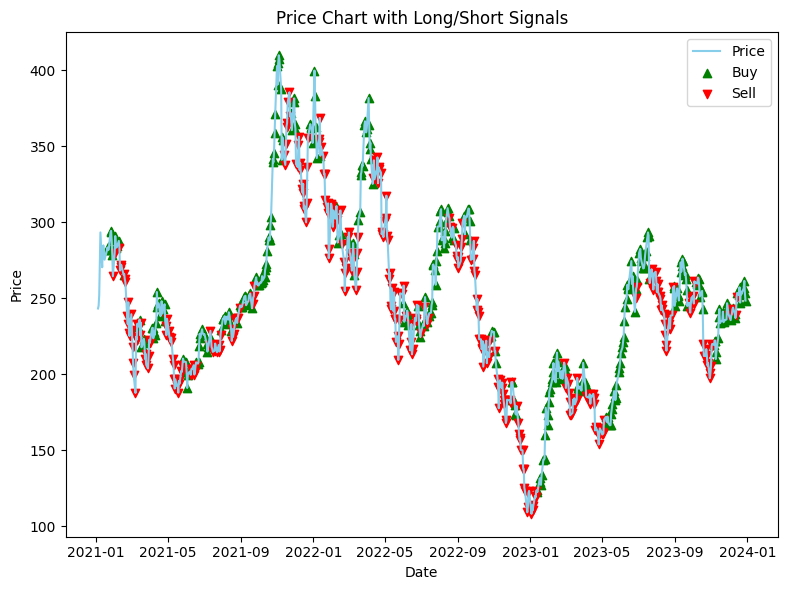

In [126]:
plot_price_with_signal(test_price, test_momentum_signal, figsize=(8, 6));

# Returns of the momentum strategy under regimes

In [127]:
if not isinstance(test_probs, pd.Series):
    test_probs = pd.Series(test_probs[:, 1], index=test_momentum_signal.index[13:])

In [152]:
df = pd.DataFrame({'ts_momentum_signal': test_momentum_signal,
                   'close': test_price,
                   'state_probs': test_probs,
                   'log_return': test_ret,
                   'volatility': exante_vol,
                   'return': np.exp(test_ret) - 1})

In [153]:
df['momentum_return'] = df['ts_momentum_signal'] * df['return']
df['momentum_cum_return'] = (1 + df['momentum_return']).cumprod()
df['state_0_momentum_return'] = df['ts_momentum_signal'] * df['return'] * np.where(df['state_probs'] < 0.5, 1, np.nan)
df['state_0_momentum_cum_return'] = (1 + df['state_0_momentum_return'].fillna(0)).cumprod()
df['state_1_momentum_return'] = df['ts_momentum_signal'] * df['return'] * np.where(df['state_probs'] >= 0.5, 1, np.nan)
df['state_1_momentum_cum_return'] = (1 + df['state_1_momentum_return'].fillna(0)).cumprod()

In [154]:
def compute_sharpe_ratio(returns, annualization_factor=252):
    return np.sqrt(annualization_factor) * returns.mean() / returns.std()

def compute_max_drawdown(returns):
    cum_returns = (1 + returns).cumprod()
    return (cum_returns / cum_returns.cummax() - 1).min()

def print_metrics(returns, annualization_factor=252):
    print(f'Annualized Return: {returns.mean() * annualization_factor:.2%}')
    print(f'Annualized Volatility: {returns.std() * np.sqrt(annualization_factor):.2%}')
    print(f'Sharp Ratio: {compute_sharpe_ratio(returns, annualization_factor):.2f}')
    print(f'Max Drawdown: {compute_max_drawdown(returns):.2%}')
    print(f'Number of Trades: {returns[returns != 0].count()}')

In [155]:
print_metrics(df['momentum_return'])

Annualized Return: 45.22%
Annualized Volatility: 58.55%
Sharp Ratio: 0.77
Max Drawdown: -52.79%
Number of Trades: 742


In [156]:
print_metrics(df['state_0_momentum_return'])

Annualized Return: 57.84%
Annualized Volatility: 49.67%
Sharp Ratio: 1.16
Max Drawdown: -38.58%
Number of Trades: 561


In [157]:
print_metrics(df['state_1_momentum_return'])

Annualized Return: 3.19%
Annualized Volatility: 80.69%
Sharp Ratio: 0.04
Max Drawdown: -60.66%
Number of Trades: 178


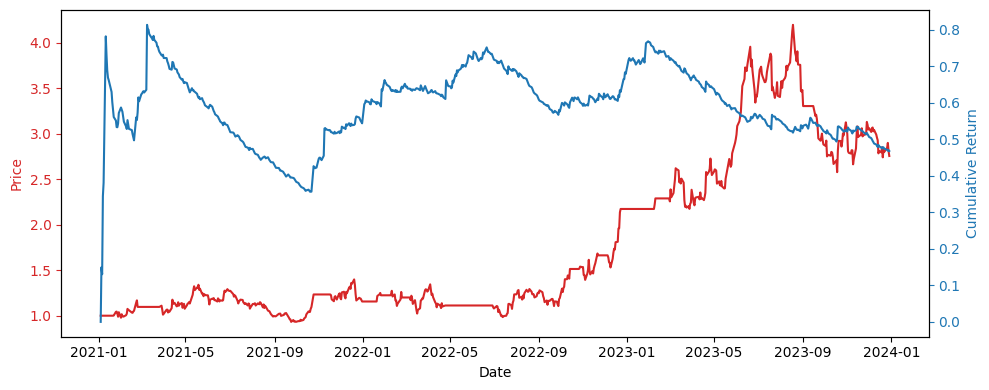

In [162]:
with set_figsize(10, 4):
    plot_shared_x(
        df.index,
        df['state_0_momentum_cum_return'],
        df['volatility'],
        xlabel='Date',
        ylabel1='Price',
        ylabel2='Cumulative Return',
    );

## Mean Reversion Strategy

In [1]:
import pandas as pd
import numpy as np

In [2]:
ff5 = pd.read_pickle('fama_french_five_factors_20180101_20231231.pkl')
tsla = pd.read_pickle('tsla_20180101_20231231.pkl')['Adj Close']

In [92]:
class SimpleMarketDataProvider:
    def __init__(self, data):
        # check if data has an index
        if not isinstance(data.index, pd.DatetimeIndex):
            raise ValueError('Data must have a datetime index')
        # check the monotonicity of the index
        if not data.index.is_monotonic_increasing:
            raise ValueError('Index must be sorted')
        self.data = data
        self.start = data.index[0]
        self.end = data.index[-1]
        
    def get_historical_data(self, start_date, end_date):
        # if start_date is not provided, set it to the start of the data
        if start_date is None or start_date == '':
            start_date = self.start
        return self.data.loc[start_date:end_date]
    
class BacktestingCalendar:
    def __init__(self, dates):
        # turn the dates into a pandas index for easier get_loc
        if isinstance(dates, pd.DatetimeIndex) and dates.dtype == '<M8[ns]':
            dates = dates.date
        self.dates = pd.Index(dates)
        self.current_date = None
        self.current_index = None
        self.length = len(dates)
        self.start = dates[0]
        self.end = dates[-1]
        
    def set_current_date(self, date):
        if date in self.dates:
            self.current_date = date
            self.current_index = self.dates.get_loc(date)
        else:
            raise ValueError('Date not in the calendar')
        
    def get_offset_date(self, offset):
        return self.dates[self.current_index + offset]
    
    def get_current_date(self):
        return self.current_date
        
    def fresh_start(self):
        self.current_date = self.start
        self.current_index = 0

    def __str__(self) -> str:
        return f'BacktestingCalendar({self.start}, {self.end}), current date: {self.current_date}'
    
    def __repr__(self) -> str:
        return str(self)

    def __iter__(self):
        if self.current_date is None or self.current_index is None:
            raise ValueError('Current date / index is not set')
        return self
    
    def __next__(self):
        if self.current_index < self.length:
            self.current_date = self.dates[self.current_index]
            self.current_index += 1
            return self.current_date
        else:
            self.current_date = None
            self.current_index = None
            raise StopIteration

In [199]:
import datetime
import quantbullet as qb
import importlib
importlib.reload(qb)
from collections import namedtuple

+-------------------------+
|  Package : quantbullet  |
|  Author  : Yiming Zhang |
|  Version : 0.1.0        |
|  Note    : BETA version |
+-------------------------+


In [258]:
tsla_log_ret = qb.compute_log_returns(tsla)
calendar = BacktestingCalendar(tsla.index)
ff5_provider = SimpleMarketDataProvider(ff5)
tsla_provider = SimpleMarketDataProvider(tsla_log_ret)

In [180]:
# X = ff5_provider.get_historical_data('2021-01-01', '2021-12-31')
# y = tsla_provider.get_historical_data('2021-01-01', '2021-12-31')
# model = qb.ols_regression(X, y)
# model.summary()

In [296]:
res = list()
OFFSET_DAYS = 125
calendar.set_current_date(datetime.date(2021, 1, 4))
OBS = namedtuple('OBS', ['date', 'resid', 'rsquared', 'f_pvalue'])
for date in calendar:
    backtest_start = calendar.get_offset_date(-OFFSET_DAYS)
    backtest_end = date
    X = ff5_provider.get_historical_data(backtest_start, backtest_end)
    y = tsla_provider.get_historical_data(backtest_start, backtest_end)
    X.index = X.index.date
    y.index = y.index.date
    model = qb.ols_regression(X, y)
    obs = OBS(date=date,
              resid=model.resid.loc[date], 
              rsquared=model.rsquared, 
              f_pvalue=model.f_pvalue)
    res.append(obs)